# 100 years $V(\lambda)$ and the future
Different candidates for different target functions?

Version 2: After a lot of discussions with colleagues from different directions (not only measurement guys)
* focus on a few spectral luminous efficiency only and not all known once
* main comparison of the original $V(\lambda)$ function and the proposed new CIE2006, 2° observer $V_\mathrm{F}(\lambda)$
* focus on the spectral luminous efficiency function only (not so much discussion about colour)


In [40]:
from scipy import rand

# temp import only
from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity

#%run -i jhelp


import luxpy as lx
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression

from empir19nrm02.f1prime import py_f1PrimeGlx
from empir19nrm02.tools import plotCorrMatrixSmall
%matplotlib inline
from luxpy import _CMF, plot_spectrum_colors
from luxpy.color.utils import plot_cmfs, plot_color_data
from luxpy.toolboxes.photbiochem import _BLH, Km_correction_factor
from luxpy.toolboxes.photbiochem import _ACTIONSPECTRA_CIES026
from luxpy.toolboxes.indvcmf import add_to_cmf_dict
from luxpy.spectrum import spd_to_xyz

from empir19nrm02 import _SPD, _RES
from empir19nrm02.tools.help import display_color_diagram, display_spectra

print('Version of luxpy:', lx.__version__)
out_dir = 'VLambda100_V2'

import os
print( 'CWD:', os.getcwd())


Version of luxpy: v1.10.0
CWD: E:\TTBV\Python\empir19nrm02\empir19nrm02\Jupyter


## Evaluating the database of target functions
### the CIE and others defined different tarkget functions in the past (extended version of luxpy)

In [41]:
print (_CMF['types'])

['1931_2', '1964_10', '2006_2', '2006_10', '2015_2', '2015_10', '1931_2_judd1951', '1931_2_juddvos1978', '1951_20_scotopic', '2006_TUIL_2', '2006_TUIL_10', '2006_UP_2', '1988_2', 'cie_std_dev_obs_f1']


### In addition to the luxpy original content the CIE1988 2° Observer was added
### CIE86:1990, Corr. 1:2005, “CIE 1988 2° SPECTRAL LUMINOUS EFFICIENCY FUNCTION FOR PHOTOPIC VISION” CIE, Vienna, Austria, 1990/20058. <https://doi.org/10.25039/TR.086.1990>

In [42]:
# to make some things a little bit easier for the display replace nan by 0
for cmf in _CMF['types']:
    _CMF[cmf]['bar'][np.isnan(_CMF[cmf]['bar'])] = 0

### Select some CMF for comparison only

In [43]:
cmfSelection = ['1931_2', '1988_2', '2006_2']
smcf_min = 1
smcf_max = 1.1
dxy_min = -0.02
dxy_max = 0.02

### Naming convention
* $V(\lambda)$ is the original one (CIE 1931, 2° standard observer)
* $V_\mathrm{M}(\lambda)$ is the CIE 1988 modified obsever (CIE86:1990)
* $V_\mathrm{F}(\lambda)$ is the new suggestion also called CIE 2006, 2° observer

In [44]:
# generate a dictionary with the color matching functions names and the right symbols --> make a dict from these data for easier usage later on
colorIndex = ['g','b','r','c','m','y','k','g-','b-','r-','c-','m-','y-','k-']
colorIndex2 = ['g--','b--','r--','c--','m--','y--','k--','g--','b--','r--','c--','m--','y--','k--']
namesIndex = ['V','V_{\mathrm{CIE1964}}','V_{\mathrm{F}}','V_{\mathrm{CIE2006,10}}','V_{\mathrm{CIE2015,2}}','V_{\mathrm{CIE2015,10}}','V_{\mathrm{Judd1951}}','V_{\mathrm{JuddVos1978}}','V^{\prime}','V_{\mathrm{TUIL,2}}','V_{\mathrm{TUIL,10}}','V_{\mathrm{UP}}','V_{\mathrm{M}}','k-']

# use the color x-bar or not
spectrum_color=False

colorData = {}
colorData2 = {}
for i, cmf in enumerate(_CMF['types']):
    colorData[cmf]  = {'color': colorIndex[i],'name': namesIndex[i]}
    colorData2[cmf]  = {'color': colorIndex2[i],'name': namesIndex[i]}

## $V(\lambda)$

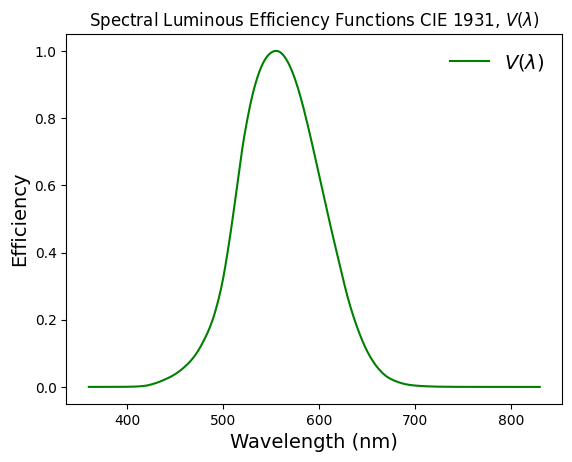

In [45]:
ax = plot_cmf2( name=cmfSelection[0], cmf_symbols=[colorData[cmfSelection[0]]['name']],
                cmf_colors = [colorData[cmfSelection[0]]['color']],  single=True, spectrum_color=spectrum_color)
ax.set_xlabel('Wavelength (nm)', fontsize=label_font_size)
ax.set_ylabel('Efficiency', fontsize=label_font_size)
ax.set_title('Spectral Luminous Efficiency Functions CIE 1931, $V(\lambda)$')
save_fig( out_dir, 'VL')

### Compare the different spectral luminous efficeiency functions

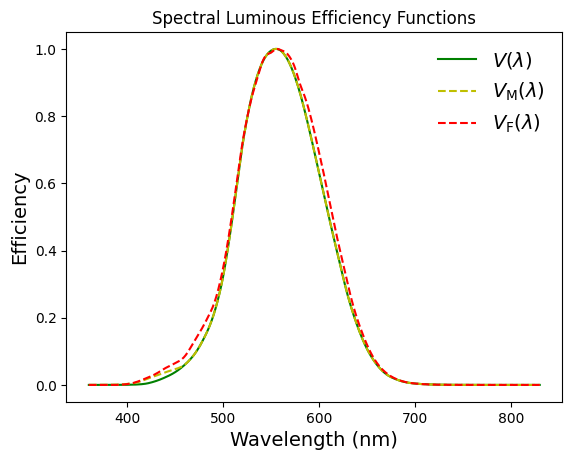

In [46]:
ax = plot_cmf2( name=cmfSelection[0], cmf_symbols=[colorData[cmfSelection[0]]['name']],
                cmf_colors = [colorData[cmfSelection[0]]['color']],  single=True, spectrum_color=spectrum_color)
for cmfTmp in cmfSelection[1:]:
    plot_cmf2( ax=ax, name=cmfTmp, cmf_symbols=[colorData[cmfTmp]['name']],
               cmf_colors = [colorData2[cmfTmp]['color']], single=True, spectrum_color=spectrum_color)
ax.set_xlabel('Wavelength (nm)', fontsize=label_font_size)
ax.set_ylabel('Efficiency', fontsize=label_font_size)
ax.set_title('Spectral Luminous Efficiency Functions')
save_fig( out_dir, 'VL_Comparison')

In [47]:
def plot_cmf2_diff( ax=None, name1 = '1931_2', name2= '2006_2', cmf_symbols = ['x', 'y', 'z'], cmf_colors = ['r-', 'g-','b-'], single = False, spectrum_color = True, xlim=None, rel=False):
    if ax is None:
        fig, ax = pyplot.subplots()
    if single:
        if rel:
            ax.plot(_CMF[name1]['bar'][0], (_CMF[name2]['bar'][2]-_CMF[name1]['bar'][2])/_CMF[name1]['bar'][2]*100, cmf_colors[0],  label='$'+ cmf_symbols[0] + 
                '(\lambda)$')
        else:
            ax.plot(_CMF[name1]['bar'][0], _CMF[name2]['bar'][2]-_CMF[name1]['bar'][2], cmf_colors[0],  label='$'+ cmf_symbols[0] + 
                '(\lambda)$')
    else:
        ax.plot(_CMF[name1]['bar'][0], _CMF[name2]['bar'][1]-_CMF[name1]['bar'][1], cmf_colors[0],  label=r'$\bar{'+cmf_symbols[0]+'}'+'(\lambda)$', lw=0.5)
        ax.plot(_CMF[name1]['bar'][0], _CMF[name2]['bar'][2]-_CMF[name1]['bar'][2], cmf_colors[1],  label=r'$\bar{'+cmf_symbols[1]+'}'+'(\lambda)$', lw=0.5)
        ax.plot(_CMF[name1]['bar'][0], _CMF[name2]['bar'][2]-_CMF[name1]['bar'][2], cmf_colors[2],  label=r'$\bar{'+cmf_symbols[2]+'}'+'(\lambda)$', lw=0.5)
    
    ax.set_xlabel('Wavelength (nm)', fontsize=label_font_size)
    if rel:
        ax.set_ylabel('rel. Difference (%)', fontsize=label_font_size)
    else:
        ax.set_ylabel('abs. Differece', fontsize=label_font_size)
    ax.legend(frameon=False, fontsize=label_font_size)
    return ax


### Plot the target function and the CIE1931_2° function

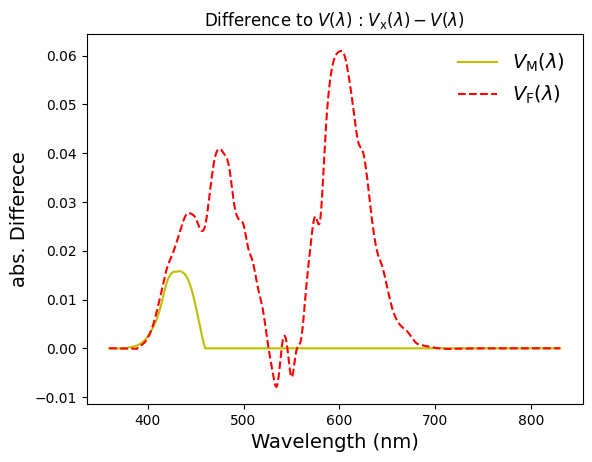

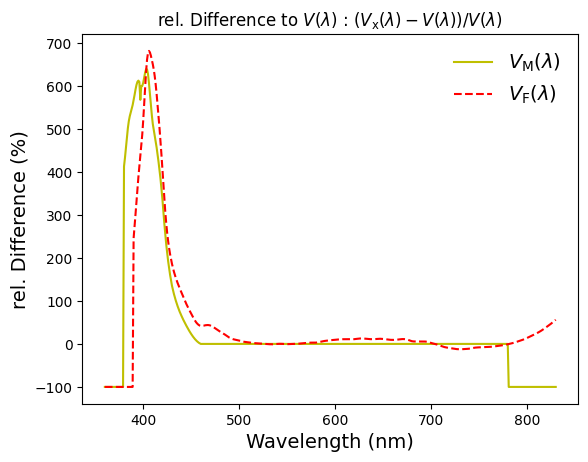

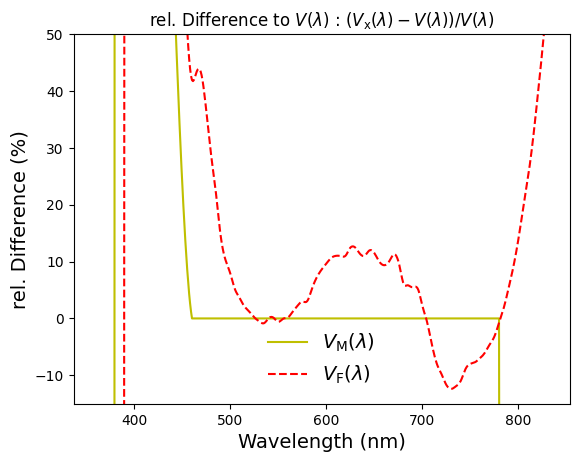

In [48]:
def plot_diff(rel=True, ylim=None):
    ax = plot_cmf2_diff( name1=cmfSelection[0], name2=cmfSelection[1],cmf_symbols=[colorData[cmfSelection[1]]['name']],cmf_colors=[colorData[cmfSelection[1]]['color']],  single=True, rel=rel)
    for cmfTmp in cmfSelection[2:]:
        plot_cmf2_diff( ax=ax, name1='1931_2', name2=cmfTmp, cmf_symbols=[colorData[cmfTmp]['name']], 
        cmf_colors = [colorData2[cmfTmp]['color']],  single=True, rel=rel)
    ax.set_xlabel('Wavelength (nm)', fontsize=label_font_size)
    if ylim is not None:
        ax.set_ylim(ylim)
    if rel:
        ax.set_title('rel. Difference to $V(\lambda)$ : $(V_{\mathrm{x}}(\lambda)-V(\lambda))/V(\lambda)$')
        save_fig( out_dir, 'VL_ComparisonDiffRel')
    else:    
        ax.set_title('Difference to $V(\lambda)$ : $V_{\mathrm{x}}(\lambda)-V(\lambda)$')
        save_fig( out_dir, 'VL_ComparisonDiffAbs')

plot_diff(rel=False)
plot_diff(rel=True)
plot_diff(rel=True, ylim=(-15,50))



# CMF data base

What is included here (including the new once)?
* Show name
* Plot compared to th CIE_1931_2° standard observer

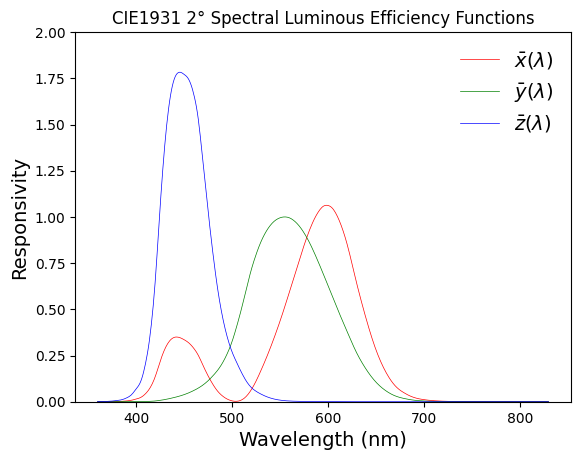

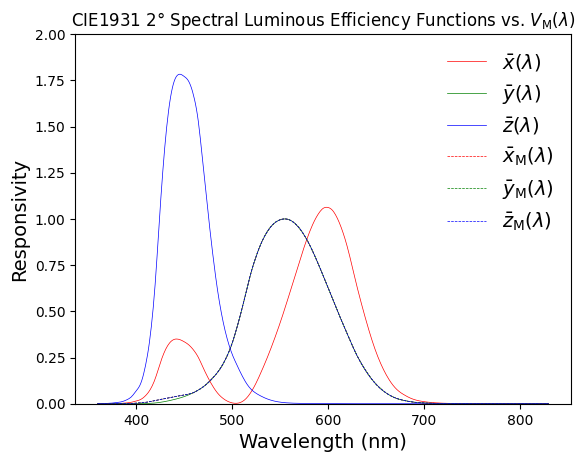

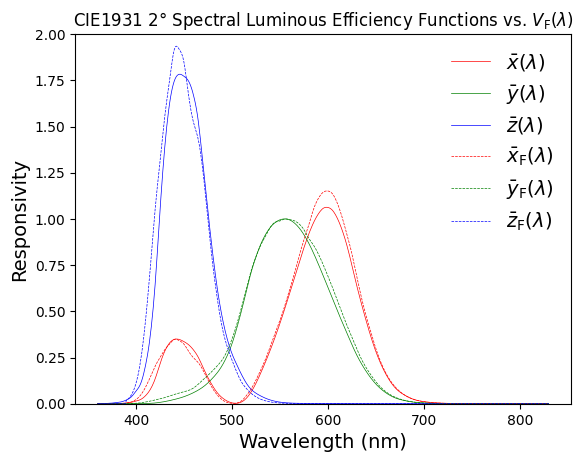

In [49]:
ax = plot_cmf2(spectrum_color=spectrum_color)
ax.set_title('CIE1931 2° Spectral Luminous Efficiency Functions')
ax.set_ylim([0, 2])
save_fig( out_dir, 'VL_' + 'org') 
for cmf in cmfSelection[1:]:
    ax = plot_cmf2(spectrum_color=spectrum_color)
    plot_cmf2(name=cmf, ax=ax, cmf_symbols = ['x'+colorData[cmf]['name'],
                                              'y'+colorData[cmf]['name'],
                                              'z'+colorData[cmf]['name']],
              cmf_colors = ['r--', 'g--', 'b--'],
              spdmax=2, spectrum_color=spectrum_color)
    ax.set_title('CIE1931 2° Spectral Luminous Efficiency Functions vs. ' + '$' + colorData[cmf]['name'] + '(\lambda)$')
    ax.set_ylim([0, 2])
    save_fig( out_dir, 'VL_' + cmf)

# SPD data base

What is included here?
* Show name
* Plot selected SD
* plot the color values in a color diagram

SPD data base:
Name: BB 			 Size: 55
Name: PTLED 			 Size: 229
Name: CIES025_PTLED 			 Size: 228
Name: OSRAM_PTLED 			 Size: 137
Name: RGBLED 			 Size: 98
Name: CIES025_RGBLED 			 Size: 97
Name: PHOTOLED 			 Size: 1496


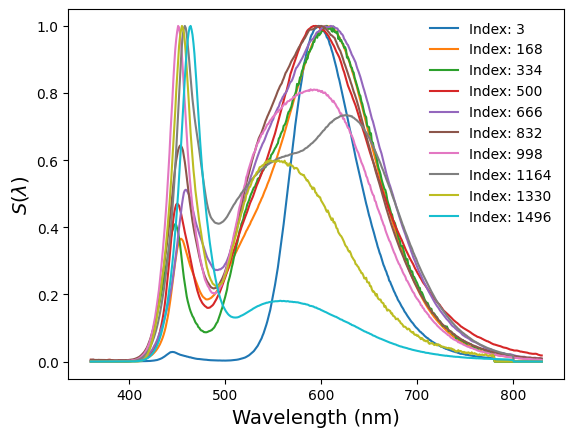

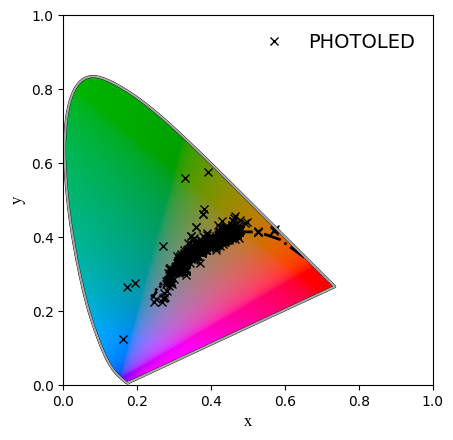

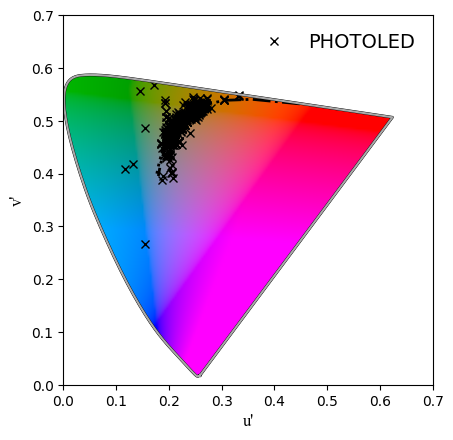

Name: TC2_90 			 Size: 1300
Name: MONOLED 			 Size: 638


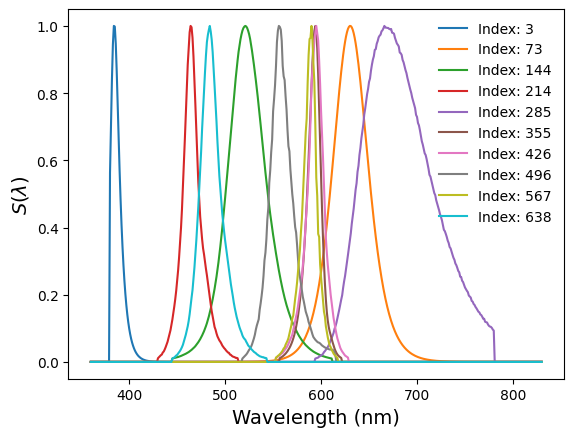

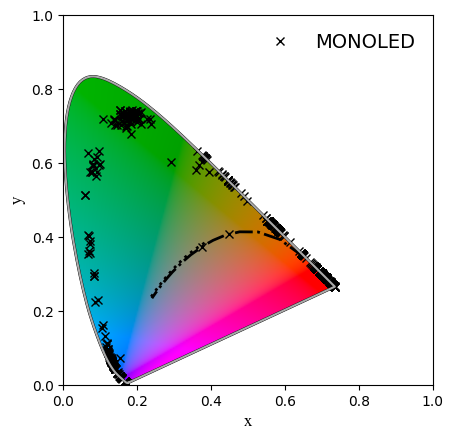

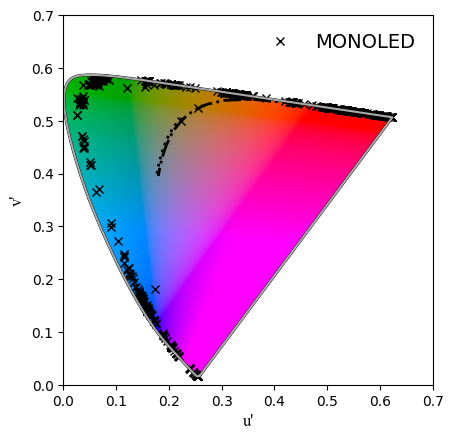

Name: OSRAM_MONOLED 			 Size: 260


In [50]:
print('SPD data base:')
for spd, enable  in _SPD.items():
    print('Name:', spd, '\t\t\t', 'Size:', _SPD[spd]['S']['data'].shape[0]-1)
    _spectra=_SPD[spd]['S']['data'].copy()
    if spd == 'PHOTOLED' or spd == 'MONOLED':
        display_spectra( spd, _spectra, curvenumber=10, legend=True)
        save_fig(out_dir, spd + '_spectra')

        display_color_diagram(spd, _spectra,cspace='Yxy')
        save_fig(out_dir, spd + '_xy')

        display_color_diagram(spd, _spectra,cspace='Yuv76')
        save_fig(out_dir, spd + '_uv76')

# Comparison

Use the data from PHOTOLED and MONOLED to compare the color values for the 1931_2 and 2006_2 observer

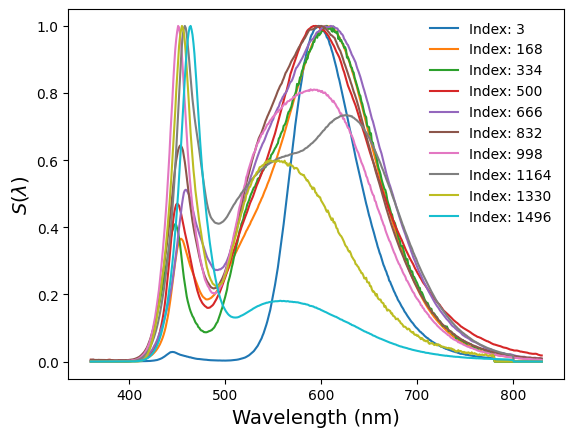

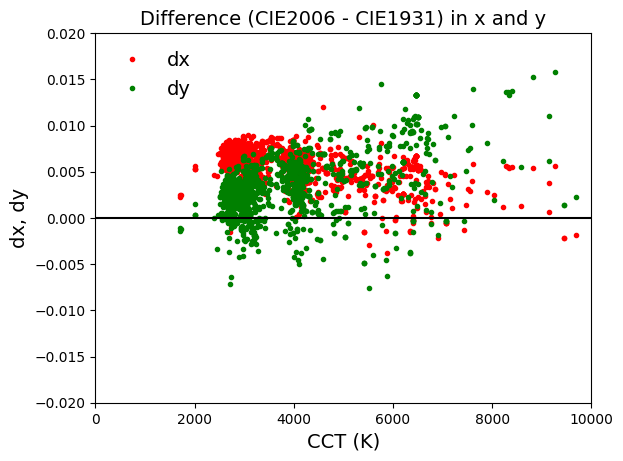

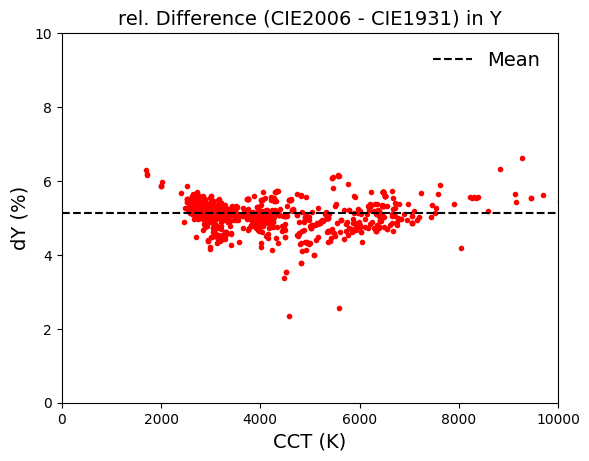

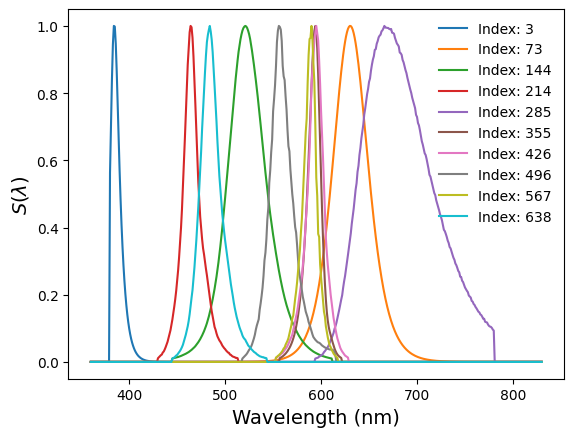

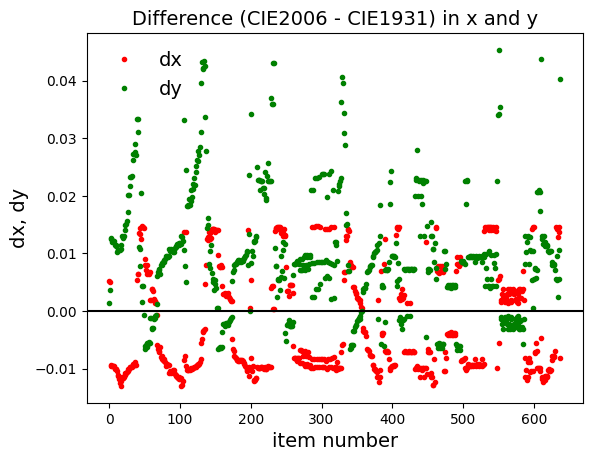

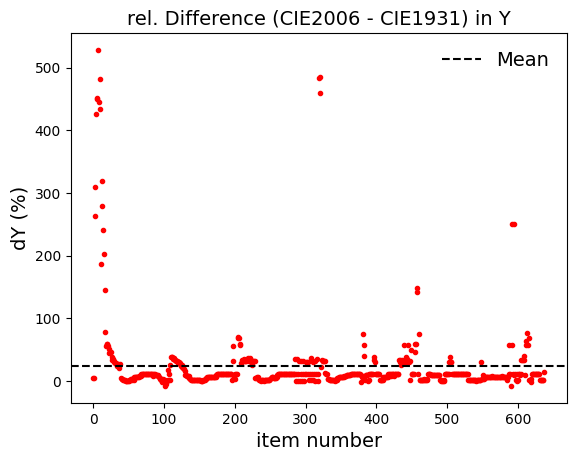

In [51]:
for spd in ['PHOTOLED', 'MONOLED']:
    _spectra=_SPD[spd]['S']['data'].copy()
    display_spectra( spd, _spectra, curvenumber=10, legend=True)
    save_fig(out_dir, spd + '_sd')
    DataCSpace0=lx.xyz_to_Yxy(lx.spd_to_xyz(_spectra, cieobs='1931_2', relative=False))
    # CCT for reference
    cct = lx.xyz_to_cct(lx.spd_to_xyz(_spectra, cieobs='1931_2'))[:,0]
    DataCSpace1=lx.xyz_to_Yxy(lx.spd_to_xyz(_spectra, cieobs='2006_2', relative=False))

    fig, ax = pyplot.subplots()
    diffData =DataCSpace1- DataCSpace0 
    if 'MONOLED' in spd:
        ax.plot( diffData.T[1], 'r.', label='dx')
        ax.plot( diffData.T[2], 'g.', label='dy')
        ax.set_xlabel('item number', fontsize = label_font_size)
    else:        
        ax.plot( cct, diffData.T[1], 'r.', label='dx')
        ax.plot( cct, diffData.T[2], 'g.', label='dy')
        ax.set_ylim( (dxy_min, dxy_max))
        ax.set_xlim( (0, 10000))
        ax.set_xlabel('CCT (K)', fontsize = label_font_size)
    
    ax.legend(frameon=False, fontsize = label_font_size)
    ax.set_ylabel('dx, dy', fontsize = label_font_size)
    ax.set_title('Difference (CIE2006 - CIE1931) in x and y', fontsize = label_font_size)
    ax.axhline(0, color = 'k')
    save_fig(out_dir, spd + 'D_xy')
    
    YDiff = (DataCSpace1.T[0]- DataCSpace0.T[0])/DataCSpace0.T[0]*100    
    fig1, ax1 = pyplot.subplots()
    if 'MONOLED' in spd:
        ax1.plot( YDiff, 'r.')
        ax1.set_xlabel('item number', fontsize = label_font_size)
    else:        
        ax1.plot( cct, YDiff, 'r.')
        ax1.set_xlim( (0, 10000))
        ax1.set_xlabel('CCT (K)', fontsize = label_font_size)
        ax1.set_ylim([(smcf_min-1.)*100,(smcf_max-1.)*100])
        YDiffPL = YDiff
        cctPL = cct
    ax1.set_title('rel. Difference (CIE2006 - CIE1931) in Y', fontsize = label_font_size)
    ax1.set_ylabel('dY (%)', fontsize = label_font_size)
    ax1.axhline(np.mean(YDiff), color='k', ls = '--', label='Mean')
    ax1.legend(frameon=False, fontsize=label_font_size)
    save_fig(out_dir, spd + '_Yrel')


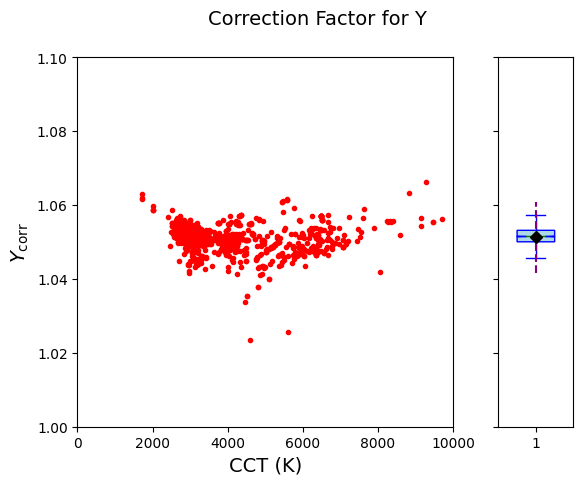

In [52]:
def simple_boxplot(ax, data, ext_sigma = 3):
    ax.boxplot( data, notch=True, patch_artist=True, showmeans=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                whiskerprops=dict(color='blue'),
                capprops=dict(color='blue'),
                flierprops=dict(marker='o', color='red', alpha=0.5),
                showfliers = False,
                medianprops=dict(color='green'),
                meanprops=dict(marker='D', markerfacecolor='black',markeredgecolor='black'),
                widths=0.5)

    # Calculate mean and standard deviation
    means = np.mean(data, axis=0)
    std_devs = np.std(data, axis=0)

    # Plot mean and ±3 standard deviation lines
    for i in range(data.shape[1]):
        ax.plot([i + 1, i + 1], [means[i] - ext_sigma * std_devs[i], means[i] + ext_sigma * std_devs[i]],   color='purple', linestyle='--')

def connected_boxplot( data):
    fig, (ax1, ax2) = pyplot.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [5, 1]})
    fig.suptitle('Correction Factor for Y', fontsize = label_font_size)
    ax1.plot( data[0], data[1], 'r.')
    ax1.set_xlim( (0, 10000))
    ax1.set_ylim( (smcf_min, smcf_max))
    ax1.set_xlabel('CCT (K)', fontsize = label_font_size)
    ax1.set_ylabel('$Y_\mathrm{corr}$', fontsize = label_font_size)
    simple_boxplot(ax2, np.expand_dims(data[1], axis=1), ext_sigma=3)

YDiffNew = YDiffPL/100+1
index_cctPL = np.where((cctPL > 0) & (cctPL < 10000))
connected_boxplot([cctPL[index_cctPL],YDiffNew[index_cctPL]])

# Radiometrie
### Let's take a black body radiator and measure the radiation

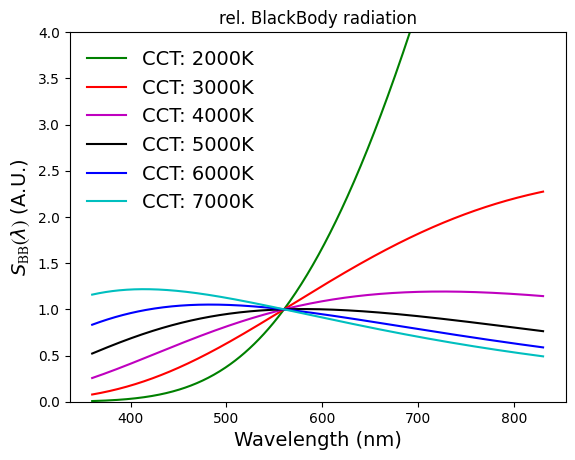

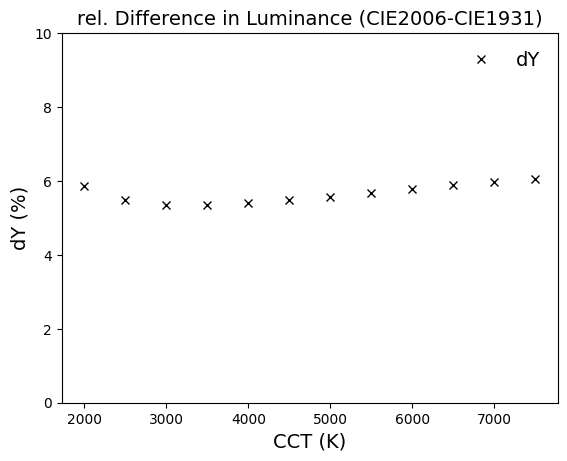

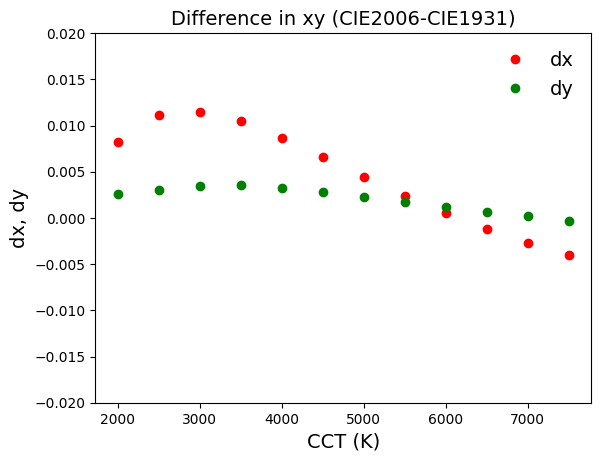

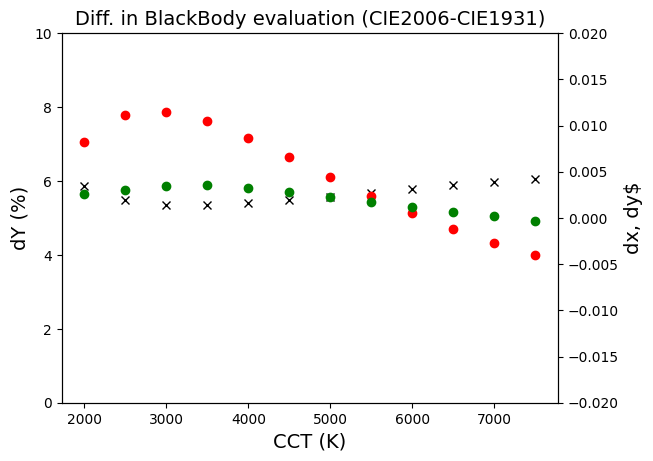

In [67]:
cct_range = [3000, 4000, 5000, 6000, 7000, 8000]
cct_range = np.arange(2000, 8000, 500)
fig, ax = pyplot.subplots()
Yxy_1932_2 = np.zeros((len(cct_range), 3))
Yxy_2006_2 = np.zeros((len(cct_range), 3))
for i, cct in enumerate(cct_range):
    s_bb=lx.blackbody( cct, lx._CMF['1931_2']['bar'][0], relative=True)
    if cct % 1000 == 0:
        ax.plot( s_bb[0], s_bb[1], colorIndex[i], label='CCT: ' + str(cct) + 'K')
    Yxy_1932_2[i] = lx.xyz_to_Yxy(lx.spd_to_xyz(s_bb, cieobs='1931_2', relative=False))
    Yxy_2006_2[i] = lx.xyz_to_Yxy(lx.spd_to_xyz(s_bb, cieobs='2006_2', relative=False))

ax.set_xlabel('Wavelength (nm)', fontsize=label_font_size)
ax.set_ylabel('$S_\mathrm{BB}(\lambda)$ (A.U.)', fontsize=label_font_size)
ax.set_ylim( (0, 4))
ax.legend(frameon=False, fontsize=label_font_size)
ax.set_title('rel. BlackBody radiation')
save_fig(out_dir, 'BB_radiation')
    
fig, ax = pyplot.subplots()
dYdata = ((Yxy_2006_2[:]-Yxy_1932_2[:])/Yxy_1932_2[:])[:,0]*100
dx_data = ((Yxy_2006_2[:]-Yxy_1932_2[:])/Yxy_1932_2[:])[:,1]
dy_data = ((Yxy_2006_2[:]-Yxy_1932_2[:])/Yxy_1932_2[:])[:,2]
ax.plot( cct_range, dYdata, 'kx', label='dY')
ax.set_xlabel('CCT (K)', fontsize=label_font_size)
ax.set_ylabel('dY (%)', fontsize=label_font_size)
ax.set_ylim([(smcf_min-1.)*100,(smcf_max-1.)*100])
ax.legend(frameon=False, fontsize=label_font_size)
ax.set_title('rel. Difference in Luminance (CIE2006-CIE1931)', fontsize=label_font_size)
save_fig(out_dir, 'BB_radiation_diffY')

fig, ax = pyplot.subplots()
ax.plot( cct_range, dx_data, 'ro', label='dx')
ax.plot( cct_range, dy_data, 'go', label='dy')
ax.set_xlabel('CCT (K)', fontsize=label_font_size)
ax.set_ylabel(r'dx, dy', fontsize=label_font_size)
ax.set_ylim(dxy_min, dxy_max)
ax.legend(frameon=False, fontsize=label_font_size)
ax.set_title('Difference in xy (CIE2006-CIE1931)', fontsize=label_font_size)
save_fig(out_dir, 'BB_radiation_diffxy')

fig, ax = pyplot.subplots()
dYdata = ((Yxy_2006_2[:]-Yxy_1932_2[:])/Yxy_1932_2[:])[:,0]*100
dx_data = ((Yxy_2006_2[:]-Yxy_1932_2[:])/Yxy_1932_2[:])[:,1]
dy_data = ((Yxy_2006_2[:]-Yxy_1932_2[:])/Yxy_1932_2[:])[:,2]
ax.plot( cct_range, dYdata, 'kx', label='dY')
ax.set_xlabel('CCT (K)', fontsize=label_font_size)
ax.set_ylabel('dY (%)', fontsize=label_font_size)
ax.set_ylim([(smcf_min-1.)*100,(smcf_max-1.)*100])
ax2 = ax.twinx()
ax2.plot( cct_range, dx_data, 'ro', label='dx')
ax2.plot( cct_range, dy_data, 'go', label='dy')
ax2.set_ylabel('dx, dy', fontsize=label_font_size)
ax2.set_ylim(dxy_min, dxy_max)
# Combine legends
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False, fontsize=label_font_size)
ax.set_title('Diff. in BlackBody evaluation (CIE2006-CIE1931)', fontsize=label_font_size)
save_fig(out_dir, 'BB_radiation_diffYdxdy')


# LMS, XYZ Variation
# Is there _ONE_ observer?

Excample from luxpy_basic_usage.ipynb


cieobs = '1964_10' # set CIE observer, i.e. cmf set
ccts = [3000,4000,4500, 6000] # define M = 4 CCTs
ref_types = ['BB','DL','cierf','DL'] # define reference illuminant types

# calculate reference illuminants:
REF = lx.cri_ref(ccts, ref_type = ref_types, norm_type = 'lambda', norm_f = 560)

print('* REF.shape --> (M + 1 x number of wavelengths): {}'.format(REF.shape)) 

In [ ]:
wl = lx._CMF['1931_2']['bar'][0]
lmin = 400
lmax = 700
# Get set of NumberObserver individual observer lms-CMFs 
NumberObserver = 1000
NumberSamples = 20

sampleIndex = np.random.randint(0, NumberObserver, NumberSamples)

print('sampleIndex:', sampleIndex)

use_model = 'us_census'
use_model = 'CIE'
# generate an array for the ages of the observers from 20 to 80 years in 10 year step mit ende 100
ages = np.arange(20, 90, 10)
# generate an array for the fieldsize of the observer 2° to 10° in 2° steps
fieldsize = np.arange(2, 12, 2)

number_of_ages = len(ages)
number_of_fieldsize = len(fieldsize)
xyz_data=np.zeros((number_of_ages, number_of_fieldsize, 4, len(wl), NumberObserver))
lms_data=np.zeros((number_of_ages, number_of_fieldsize, 4, len(wl), NumberObserver))
for a, age in enumerate(ages):
    for f, field in enumerate(fieldsize):
        if use_model == 'CIE':
            xyzb = lx.indvcmf.genMonteCarloObs(n_obs = NumberObserver, list_Age = [age], fieldsize = field, out ='XYZ', wl=wl)
            lmsb = lx.indvcmf.genMonteCarloObs(n_obs = NumberObserver, list_Age = [age], fieldsize = field, out ='LMS', wl=wl)
            xyz_data[a,f] = xyzb
            lms_data[a,f] = lmsb
            titleStr = 'CIE 2006'
        
#    if use_model == 'us_census':
#    # Use US 2010 population census to generate Age Distribution and output as XYZ CMF:
#    xyzb_us = lx.indvcmf.genMonteCarloObs(n_obs = NumberObserver, list_Age = 'us_census', fieldsize = 2, out ='XYZ')
#    lmsb_us = lx.indvcmf.genMonteCarloObs(n_obs = NumberObserver, list_Age = 'us_census', fieldsize = 2, out ='LMS')
#    xyz_data = xyzb_us
#    lms_data = lmsb_us
#    titleStr = 'US 2010 population census' 




In [ ]:
# Plot CMFs:
a=1
f=0

refDataXYZ = lx._CMF['1931_2']['bar']

titleStr2=titleStr + ' Age ' + str(ages[a]) + ' Field ' + str(fieldsize[f]) + '°'

pyplot.figure()

pyplot.plot(xyz_data[a,f,0,:,sampleIndex],xyz_data[a,f,1,:,sampleIndex], color ='r', linestyle='-')
pyplot.plot(xyz_data[a,f,0,:,sampleIndex],xyz_data[a,f,2,:,sampleIndex], color ='g', linestyle='-')
pyplot.plot(xyz_data[a,f,0,:,sampleIndex],xyz_data[a,f,3,:,sampleIndex], color ='b', linestyle='-')

pyplot.plot(refDataXYZ[0],refDataXYZ[1], color ='k', linestyle='-')
pyplot.plot(refDataXYZ[0],refDataXYZ[2], color ='k', linestyle='-')
pyplot.plot(refDataXYZ[0],refDataXYZ[3], color ='k', linestyle='-')

# Add bar with wavelength colors:
#lx.plot_spectrum_colors(wavelength_height = -0.05,spdmax = 2.4, axh = pyplot.gca())
pyplot.xlabel('Wavelength (nm)')
pyplot.ylabel('XYZbar (area normalized)')
pyplot.title(titleStr2)
pyplot.ylim(0, 2.5)
pyplot.xlim(lmin, lmax)
save_fig( out_dir, titleStr2 + '_XYZ')

# Plot CMFs:
pyplot.figure()

pyplot.plot(lms_data[a,f,0,:,sampleIndex],lms_data[a,f,1,:,sampleIndex], color ='r', linestyle='-')
pyplot.plot(lms_data[a,f,0,:,sampleIndex],lms_data[a,f,2,:,sampleIndex], color ='g', linestyle='-')
pyplot.plot(lms_data[a,f,0,:,sampleIndex],lms_data[a,f,3,:,sampleIndex], color ='b', linestyle='-')
# Add bar with wavelength colors:
#lx.plot_spectrum_colors(wavelength_height = -0.05,spdmax = 1.2, axh = pyplot.gca())
pyplot.ylim(0, 1.2)
pyplot.xlim(lmin, lmax)
pyplot.xlabel('Wavelength (nm)')
pyplot.ylabel('LMSbar (area normalized)')
pyplot.title(titleStr2)
save_fig( out_dir, titleStr2 + '_LMS')


In [ ]:
# Plot CMFs:
pyplot.figure()
a=0
f=0

for a, age in enumerate(ages):
    #for f, field in enumerate(fieldsize):
        nu = np.mean(xyz_data[a,f,2,:,:], axis=-1)
        de = lx._CMF['2006_2']['bar'][2]
        rel = np.divide(nu, de, out=np.zeros_like(nu), where=de!=0)
        pyplot.plot(xyz_data[a,f,0,:,0],rel, color =colorIndex[a], linestyle='-', label='Age: ' + str(age) + ' years')
pyplot.legend()    
pyplot.xlabel('Wavelength (nm)')
pyplot.xlim(lmin, lmax)
pyplot.ylim(0, 2)
pyplot.ylabel('rel. spectral responsivity change')
pyplot.title('Age related change in Ybar, ref. CIE2006_2')
save_fig( out_dir, 'AgeRelatedChangeBar' + '_Y')


In [ ]:
# Plot CMFs:
pyplot.figure()
a=1
f=0

#for a, age in enumerate(ages):
for f, field in enumerate(fieldsize):
    nu = np.mean(xyz_data[a,f,2,:,:], axis=-1)
    de = lx._CMF['2006_2']['bar'][2]
    rel = np.divide(nu, de, out=np.zeros_like(nu), where=de!=0)
    pyplot.plot(xyz_data[a,f,0,:,0],rel, color =colorIndex[f], linestyle='-', label='Field: ' + str(field) + ' °')
pyplot.legend()    
# Add bar with wavelength colors:
#lx.plot_spectrum_colors(wavelength_height = -0.05,spdmax = 1.2, axh = pyplot.gca())
pyplot.xlabel('Wavelength (nm)')
pyplot.xlim(lmin, lmax)
pyplot.ylim(0, 2)
pyplot.ylabel('rel. spectral responsivity change')
pyplot.title('Field related change in Ybar @ Age ' + str(ages[a]) + ' years ref. CIE2006_2')
save_fig( out_dir, 'FieldRelatedChangeBar' + '_Y')

In [ ]:
#for spd in ['PHOTOLED', 'MONOLED']:
refStr = '1931_2'
for spd in ['PHOTOLED']:
    _spectra=_SPD[spd]['S']['data'].copy()
    # CalculateXYZ values for _spectra:
    #Yxy_ind = np.empty((number_of_ages, number_of_fieldsize,_spectra.shape[0]-1, xyz_data.shape[-1],3))
    Yxy_ind = np.empty((number_of_ages, number_of_fieldsize,_spectra.shape[0]-1, xyz_data.shape[-1],3))
    Yxy_ref = lx.xyz_to_Yxy(lx.spd_to_xyz(_spectra, cieobs = refStr,relative = False, K=1))
    xyz_data_0 = xyz_data[0,0].copy()
    Yxy_ref1 = lx.xyz_to_Yxy(lx.spd_to_xyz(_spectra, cieobs = xyz_data_0[...,0],relative = False, K=1))
    for a, age in enumerate(ages):
        for f, field in enumerate(fieldsize):
            xyz_data_tmp = xyz_data[a,f].copy()
            for i in range(xyz_data.shape[-1]):
                Yxy_ind[a,f,:,i,:] = lx.xyz_to_Yxy(lx.spd_to_xyz(_spectra, cieobs = xyz_data_tmp[...,i],relative = False, K=1))


In [ ]:
yminBox=0.9
ymaxBox=1.2

In [ ]:
meanTest = np.mean(Yxy_ind, axis=3)
fig, ax = pyplot.subplots()
a = 1
data = np.zeros((number_of_fieldsize, _spectra.shape[0]-1))
for f, field in enumerate(fieldsize):
    data[f] = meanTest[a,f,:,0]/Yxy_ref[:,0]
    ax.plot( data[f], color = colorIndex[f], linestyle='-', label='Field: ' + str(field) + '°')

fig1, ax1 = pyplot.subplots()
ax1.boxplot(data.T, positions = [i for i in fieldsize], widths=0.5, labels=fieldsize, showmeans=True, showfliers=False)
pyplot.xlabel('Fieldsize (°)')
pyplot.ylabel('luminance factor rel. to '+refStr)
pyplot.ylim(yminBox, ymaxBox)
pyplot.title('Field related change in Y @ Age ' + str(ages[a]) + ' ref. ' + refStr)
save_fig( out_dir, 'FieldRelatedChange'+ refStr+ '_Y')
    

In [ ]:
fig, ax = pyplot.subplots()
f = 0
data = np.zeros((number_of_ages, _spectra.shape[0]-1))
for a, age in enumerate(ages):
    data[a] = meanTest[a,f,:,0]/Yxy_ref[:,0]
    ax.plot( data[a], color = colorIndex[a], linestyle='-', label='Age: ' + str(age))

fig1, ax1 = pyplot.subplots()
ax1.boxplot(data.T, positions = [i for i in ages], widths=5, labels=ages, showmeans=True, showfliers=False)
pyplot.xlabel('Age (year)')
pyplot.ylim(yminBox, ymaxBox)

pyplot.ylabel('luminance factor rel. to '+refStr)
pyplot.title('Age related change in Y @ Field ' + str(fieldsize[f]) + ' ref. ' + refStr)
save_fig( out_dir, 'AgeRelatedChange' + refStr+ '_Y')    

In [ ]:
    fig, (ax1, ax2) = pyplot.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [5, 1]})
    fig.suptitle('rel. Difference in Y Age:' + str(ages[-1]) )
    YDiffNew = data[number_of_ages-1]
    ax1.plot( cctPL, YDiffNew, 'r.')
    ax1.set_xlim( (2000, 10000))
    ax1.set_ylim((yminBox, ymaxBox))
    ax1.set_xlabel('CCT / K')        
    ax1.set_ylabel('dY / %')
    ax2.boxplot(YDiffNew, showmeans=True, showfliers=False, widths=0.5)

    save_fig(out_dir, 'YRelBox2' + '_Yrel')

In [ ]:
fig, ax = pyplot.subplots()
    
stdYxy = np.std(Yxy_ind[1,0,:,:,:], axis=1)
ax.plot( cctPL, stdYxy[:,0]/np.mean(Yxy_ind[1,0,:,:,:], axis=1)[:,0]*100, 'rx')
ax.set_xlabel('CCT / K')
ax.set_xlim( (0, 10000))
ax.set_ylabel('std(Y) / mean(Y) / %')
ax.set_title('Variation in Y '+ titleStr)    
save_fig( out_dir, titleStr + '_stdY')

fig, ax = pyplot.subplots()

ax.plot( cctPL, stdYxy[:,1], 'rx')
ax.plot( cctPL, stdYxy[:,2], 'go')
ax.set_xlabel('CCT / K')
ax.set_xlim( (0, 10000))
ax.set_ylabel('std(x), std(y)')
ax.set_title('Variation in x,y '+ titleStr)    
save_fig( out_dir, titleStr + '__stdxy')

# Calculate $f_1'(\lambda)$ for the V(λ) functions

In [ ]:
from empir19nrm02.f1prime import py_f1Prime

erg = np.zeros( len(_CMF['types']))
fig, ax = pyplot.subplots()
for i, cmf in enumerate(_CMF['types']):
    if '1951' in cmf or 'std' in cmf:
        erg[i] = 0
    else:        
        erg[i],_ = py_f1Prime(_CMF[cmf]['bar'][0], _CMF[cmf]['bar'][2])
    print( cmf, erg[i])
ax.plot(erg*100, 'rx')
pyplot.xticks( range(len(_CMF['types'])), _CMF['types'], rotation ='vertical')
ax.set_xlabel('CMF')
ax.set_ylabel(strd['f1p'] + '/ %')
ax.set_title(strd['f1p'] + ' for different CMF')
save_fig( out_dir, 'CMF' + '_f1Prime')